In [1]:
import spacy
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from spacy.matcher import Matcher
import scipy

In [2]:
#!python -m spacy download en_core_web_sm

In [3]:
ELM = spacy.load('en_core_web_sm')

In [4]:
print(ELM)

# Used functions

In [5]:
# Filter entities that exist in the character dataframe
def filter_entity(ent_list,character_df):
    return[ent for ent in ent_list
           if ent in list(character_df.Characters)
           or ent in list(character_df.Firstname)
           or ent in list(character_df.Nickname)
           or ent in list(character_df.Nickname2)]

# Load the document and data

In [6]:
text = open(file= 'data/jane-austen-pride-prejudice.txt').read()
doc_texto = ELM(text)

In [7]:
data_characters = pd.read_excel('data/characters.xlsx')
data_characters.head()

,Characters,Firstname,Nickname,Nickname2,real_name
0,Mr. Bennet,Mr. Bennet,Bennet,NaN,Mr. Bennet/Mrs.Bennet
1,Mrs. Bennet,Mrs. Bennet,Bennet,NaN,Mr. Bennet/Mrs.Bennet
2,Jane Bennet,Jane,NaN,NaN,Jane Bennet
3,Miss Elizabeth Bennet,Elizabeth,Eliza,Lizzy,Elizabeth
4,Mary Bennet,Mary,NaN,NaN,Mary Bennet


In [8]:
#Let’s take a look at the document
spacy.displacy.render(doc_texto[0:150],style = "ent",jupyter = True)

Let's get started, first of all, we're gonna have to build a pandas dataframe with our sentences and use the NLP model to recognize entities.

In [9]:
#Define how our model should find vocabulary patters
matcher = Matcher(ELM.vocab)
pattern = [{'POS':'PROPN'},{'POS':'PROPN'}]
matcher.add('rule a ',[pattern])
matches = matcher(doc_texto)

In [10]:
# Split all the sentences and entities into a dataframe
sent_entity_df = []
for i in doc_texto.sents:
    entiti_list = [i.text for i in i.ents if i.label_ == "PERSON"]
    sent_entity_df.append({"sentence": i , "entities": entiti_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

In [11]:
sent_entity_df.head()

,sentence,entities
0,"(ï»¿CHAPTER, I., \n\n)",[ï»¿CHAPTER I.\n\n]
1,"(It, is, a, truth, universally, acknowledged, ...",[]
2,"(However, little, known, the, feelings, or, vi...",[]
3,"("", My, dear, Mr., Bennet, ,, "", said, his, la...",[Bennet]
4,"("", \n\n, Mr., Bennet, replied, that, he, had,...",[Bennet]


In [12]:
#Let's try the function
filter_entity(["Lady Catherine","Thu","2"],data_characters)

['Lady Catherine']

In [13]:
# Using the function to extract the characters in the sentence
sent_entity_df['characters_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x,data_characters))
# Make a dataframe with the characters entities only
sent_entity_df_filtered = sent_entity_df[sent_entity_df['characters_entities'].map(len)> 0]

In [14]:
sent_entity_df_filtered.head()

,sentence,entities,characters_entities
3,"("", My, dear, Mr., Bennet, ,, "", said, his, la...",[Bennet],[Bennet]
4,"("", \n\n, Mr., Bennet, replied, that, he, had,...",[Bennet],[Bennet]
5,"("", But, it, is, ,, "", returned, she, ;, "", fo...",[Long],[Long]
6,"("", \n\n, Mr., Bennet, made, no, answer, ., \n\n)",[Bennet],[Bennet]
10,"("", Why, ,, my, dear, ,, you, must, know, ,, M...","[Long, Morris, Michaelmas]","[Long, Morris]"


## Now we're gonna get all of these characters entities that we found and calculate the relationship between them

In [15]:
window_size = 5 # iterate 5 setences
relationships = [] # Initializes an empty list of relationships.

# Starts a for loop iterating the indices of the dataframe
for i in range(sent_entity_df_filtered.index[-1]): 
    # Ensures that the ending index does not exceed the dataframe size
    end_i = min(i+window_size, sent_entity_df_filtered.index[-1])
    # Sums all the characters found within a range of rows defined by end_i
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].characters_entities), []) 
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    # create a list of relationship
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [16]:
#Create a dataframe with characters relationship
relation_df = pd.DataFrame(relationships)

In [17]:
relation_df.head(5)

,source,target
0,Bennet,Long
1,Bennet,Long
2,Long,Bennet
3,Bennet,Long
4,Long,Bennet


In [18]:
relation_df["value"] = 1
relationship_df = relation_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [19]:
relationship_df.head(10)

,source,target,value
0,Bennet,Long,14
1,Long,Bennet,19
2,Long,Morris,6
3,Bingley,William,8
4,William,Lady Lucas,18
5,Lady Lucas,Bingley,3
6,Bingley,Lizzy,21
7,Lizzy,Jane,36
8,Jane,Lizzy,72
9,Lizzy,Bennet,29


In [20]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())
#communities = nx.community.louvain_communities(G,seed=42)
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G,communities,'group')

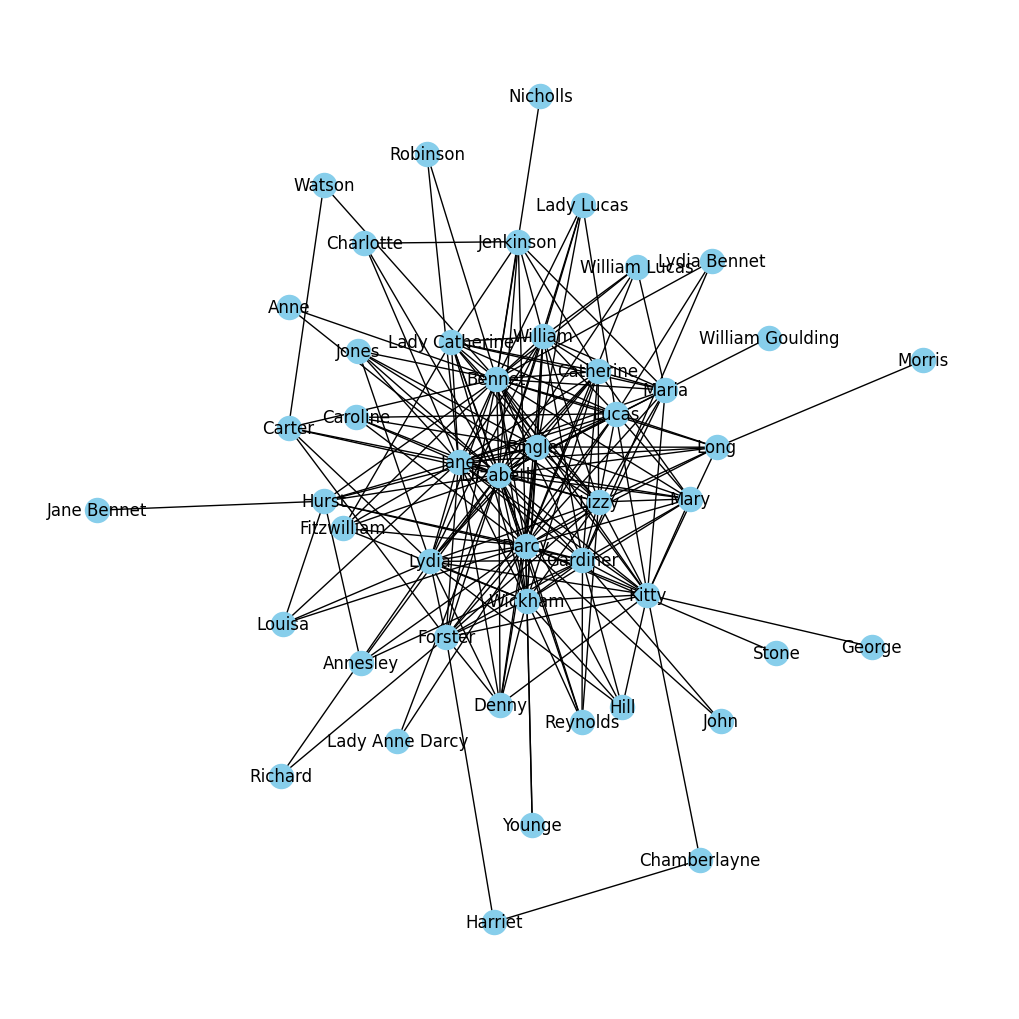

In [21]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [22]:
from pyvis.network import Network
net = Network(notebook=True, width="100%",height="1080px",bgcolor='#222222',font_color= "white",neighborhood_highlight=True)
net.barnes_hut(gravity= -800)
net.from_nx(G)
net.show('index.html')

index.html
